**тематическое моделирование**

Евгений Борисов borisov.e@solarl.ru

In [1]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

# разложение частотной матрицы [ слова x документы ]  
#
# получаем матрицу с описанием тем [ слова х темы ]   
# и матрицу вероятностей событий "тема описывает документ"  [ темы х документы ]
# 
# [ слова x документы ] = [ слова х темы ] * [ темы х документы ]
# 
# p(w|d) = p(w|t) * p(t|d)

## библиотеки

In [2]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from pymorphy2 import MorphAnalyzer

SKLEARN_VERSION

'0.24.1'

## тексты

In [4]:
data = pd.read_pickle('../data/news.pkl.gz')
print('текстов:',len(data))
data.sample(4)

текстов: 3196


,text,tag
1009,Торговля перешла на экономрежим\n\n30 ноября 2016 в 19:14\n\nАлександр Заяц / TUT.BY\n\nБелорусские ритейлеры в условиях падения доходов населения и увеличения административных издержек вынуждены ...,economics
2276,"На магистрали Кемерово – Ленинск-Кузнецкий произошло сразу несколько аварий в общей сложности с участием восьми машин.\n\nВо вторник, 13 декабря, на 15 километре автомагистрали Кемерово – Ленинск-...",incident
1393,"Москва, 13 декабря. Опрос, проведенный социологическим «Аналитическим центром Юрия Левады» показал, что три четверти россиян уверены в том, что президент Владимир Путин последовательно работает на...",politics
252,"Пугачева за 1 млн долларов рассказала о любви и разводе с Киркоровым Якобы,\nобедая в ресторане с известным пародистом и телеведущим, Алла Борисовна\nзаявила официанту, ""они с мужем"" желают заказа...",culture


## токенизация и очистка

In [5]:
from nltk.corpus import stopwords as nltk_stopwords
stopwords = set(nltk_stopwords.words('russian'))

In [6]:
# лемматизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()

# NOUN	существительное
# VERB	глагол
# ADJF	прилагательное
def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''

def string_normalizer(s):
    return re.sub(r'[\W]+',' ',s.lower().replace('ё','е'))

def text_normalizer(s):
    return [ word_normalizer(w) for w in string_normalizer(s).split() ]

def drop_stopwords(s):
    return [ w for w in s if ( w not in stopwords ) ]

In [7]:
data['ctext'] = data['text']\
        .progress_apply(text_normalizer)\
        .progress_apply(drop_stopwords)\
        .apply(' '.join)

100%|██████████| 3196/3196 [00:00<00:00, 58665.96it/s]


## модели

In [8]:
def print_top_words(model, feature_names, n_top_words=7):
    for topic_idx, topic in enumerate(model.components_):
        message = "Тема %d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [9]:
n_features = 1000
n_components = 10

### CountVectorizer + LatentDirichletAllocation

In [10]:
# tf features 
tf_vectorizer = CountVectorizer( max_df=0.95, min_df=2, max_features=n_features )
tf = tf_vectorizer.fit_transform(data['ctext'])
tf_feature_names = tf_vectorizer.get_feature_names()

# LDA - латентное размещение Дирихле
lda = LatentDirichletAllocation( n_components=n_components, max_iter=5, 
                                learning_method='online', learning_offset=50.,
                                random_state=0 ).fit(tf)
print('\nLDA:\n')
print_top_words(lda, tf_feature_names)


LDA:

Тема 0: год россия народ глава декабрь министр президент
Тема 1: год тысяча доллар рубль декабрь мир миллион
Тема 2: год который новый фильм мочь учёный самый
Тема 3: компания автомобиль рубль рынок банк млн который
Тема 4: хороший матч команда который свой стать мяч
Тема 5: дом квартира ул музей работа выставка центр
Тема 6: служба информация сообщение сообщать сайт москва год
Тема 7: который мочь свой человек весь беларусь наш
Тема 8: сша трамп президент свой американский который дональд
Тема 9: человек декабрь район который место женщина водитель


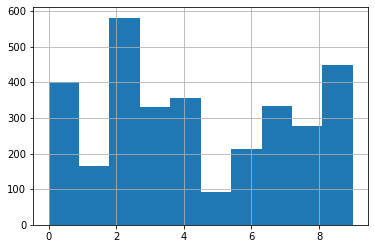

In [11]:
t = np.argmax(lda.transform(tf),axis=1) 
plt.hist(t)
plt.grid()

### TfidfVectorizer + NMF (Frobenius norm)

In [12]:
# tf-idf features 
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features)

tfidf = tfidf_vectorizer.fit_transform(data['ctext'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# NMF (Frobenius norm) - неотрицательное матричное разложение
nmf = NMF( n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5 ).fit(tfidf)

print('\nNMF:\n')
print_top_words( nmf, tfidf_feature_names )

/usr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



NMF:

Тема 0: президент россия путин япония министр глава государство
Тема 1: трамп сша президент дональд избранный выборы бизнес
Тема 2: матч чемпионат команда очко динамо лига шахтёр
Тема 3: водитель дтп авария произойти автобус летний автомобиль
Тема 4: автомобиль модель компания новый рынок год версия
Тема 5: год который человек учёный мочь свой весь
Тема 6: савченко депутат надежда украина партия лидер народный
Тема 7: фильм хороший премия награда номинация актёр картина
Тема 8: рубль доллар млрд млн цена год нефть
Тема 9: народ коренной север малочисленный край фестиваль район


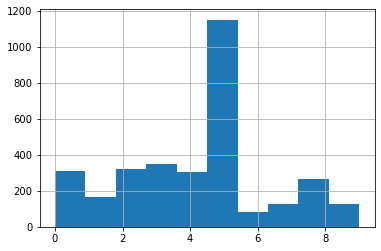

In [13]:
t = np.argmax(nmf.transform(tfidf),axis=1) 
plt.hist(t)
plt.grid()

### TfidfVectorizer + NMF (generalized Kullback-Leibler divergence)

In [14]:
# tf-idf features 
tfidf_vectorizer = TfidfVectorizer( max_df=0.95, min_df=2, max_features=n_features)

tfidf = tfidf_vectorizer.fit_transform(data['ctext'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# NMF (generalized Kullback-Leibler divergence) 
nmf = NMF( n_components=n_components, random_state=1, beta_loss='kullback-leibler', 
          solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5 ).fit(tfidf)

print('\nNMF:\n')
print_top_words( nmf, tfidf_feature_names )

/usr/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



NMF:

Тема 0: год который декабрь мочь россия беларусь компания
Тема 1: президент трамп сша министр глава выборы путин
Тема 2: матч чемпионат команда клуб сборная чемпион мир
Тема 3: водитель летний дтп произойти декабрь результат человек
Тема 4: автомобиль модель компания новый версия машина год
Тема 5: учёный человек который женщина мочь самый жизнь
Тема 6: украина савченко союз депутат партия лидер надежда
Тема 7: фильм хороший нефть премия год актёр конкурс
Тема 8: рубль дом млн доллар млрд работа год
Тема 9: народ коренной север малочисленный город самолёт центр


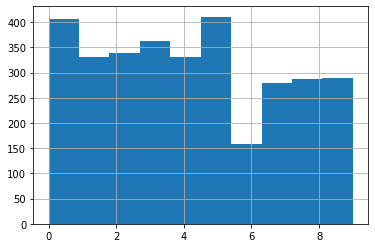

In [15]:
t = np.argmax(nmf.transform(tfidf),axis=1) 
plt.hist(t)
plt.grid()